<a href="https://colab.research.google.com/github/youngsoopar/Aiffel_practice/blob/main/CV%20starting%20with%20deep%20learning/CV_starting_with_deep_learning_Chapter_7.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from IPython.display import Image
from google.colab import drive
drive.mount('/gdrive', force_remount=True)

# Transfer Learning

<br>
<br>

## 1. Transfer Learning 필요성
  - #### 대규모 모델의 발전에 따라 많은 양의 데이터가 필요
  - #### 충분한 Train, test 셋을 모아야 하며 질적으로도 충분해야함.
  - #### 그만큼 대규모 모델을 만듬에 있어 금전적, 시간적 비용이 커지게 되었음.


## 2. Transfer Learning (전이학습)이란?
  - #### '이미지 분류' 문제를 해결하는데 사용했던 네트워크(DNN;Deep Neural Network)를 다른 데이터셋 혹은 다른 문제(task)에 적용시켜 푸는 것을 의미
  - #### 네트워크가 다양한 이미지의 보편적인 특징 혹은 피쳐를 학습
  - #### 이런 네트워크들이 학습한 데이터셋으로 유명한 것은 ImageNet.
  - #### 대표적은 base로는 AlexNet, VGG, GoogleNet, ResNet

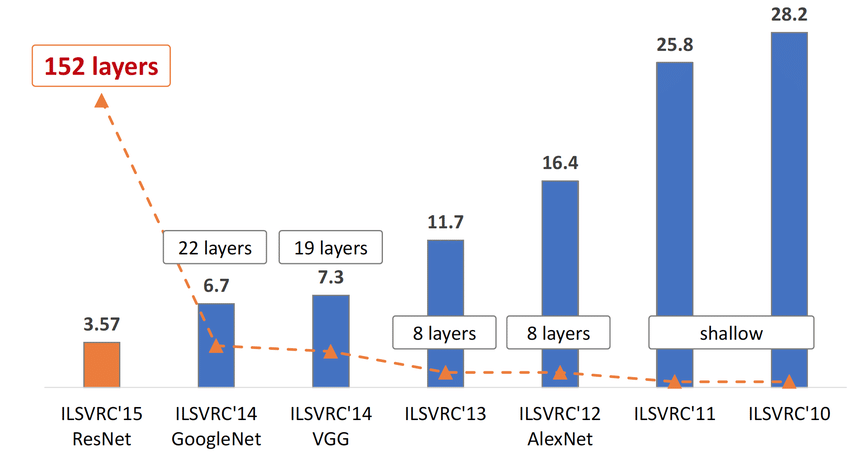

In [10]:
Image('/gdrive/My Drive/Deep learning/CV starting with deep learning/ILSVRC.png', width= 800, height = 400)

## 3. Transfer Learning 효과
  - #### 학습된 모델을 사용하여 새로운 모델을 만들 수 있음
  - #### 학습을 빠르게 하며 예측 능력을 향상 가능
  - #### 더 복잡한 모델 학습가능 및 연산 비용을 절감
<br>

  - ### 처음부터 학습과 전이학습 비교
    - #### 처음부터 학습
      - 파라미터 초기화, 학습 등 모든 과정의 코드를 작성 및 실행
      - loss 값을 보며 충분한 성능이 구현될때까지 학습 진행

    - #### 전이학습
      - 이미 학습된 모델의 파라미터 값들을 가져다 이용
      - 파라미터 전체 또는 일부만 학습 가능

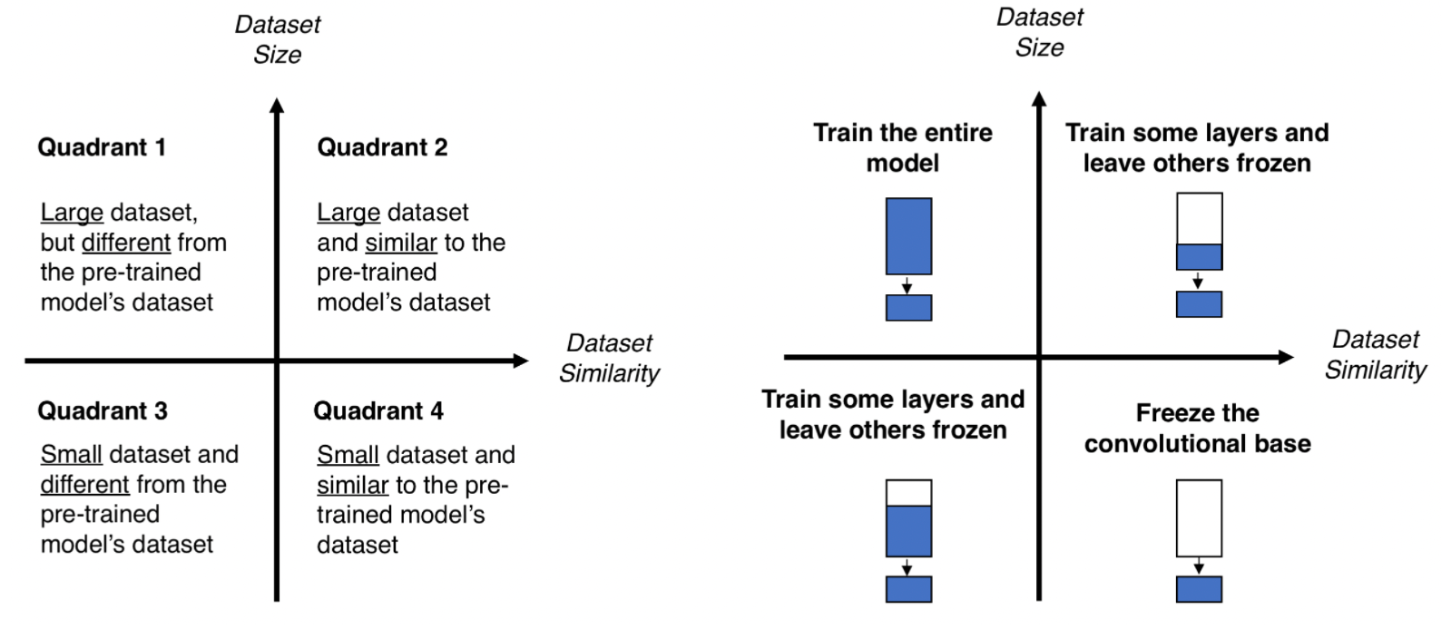

In [6]:
Image('/gdrive/My Drive/Deep learning/CV starting with deep learning/전이학습 dataset.png', width= 1000, height = 400)

- ### 4. Transfer learning의 적용
  - #### 1) 데이터 유사성이 높을 때
    - 보유 데이터 셋이 클 경우 : 많은 부분을 freeze 시키고 뒷단의 조금만 train
    - 보유 데이터 셋이 작을 경우 : Task-specific한 부분만 train

  - #### 2) 데이터 유사성이 낮을 때
    - 보유 데이터 셋이 클 경우 : Transfer learning 적용 X
    - 보유 데이터 셋이 작을 경우 : 일반적 feature만 freeze

## 5. 코드 실습

In [ ]:
!mkdir -p aiffel/cifar_10_small

!ln -s ~/data/cifar_10_small/train/ aiffel/cifar_10_small/train
!ln -s ~/data/cifar_10_small/test/ aiffel/cifar_10_small/test
import os
import tensorflow as tf
import matplotlib.pyplot as plt

In [ ]:
train_dir='aiffel/cifar_10_small/train'
test_dir='aiffel/cifar_10_small/test'

train_aeroplane_dir= os.path.join(train_dir,'aeroplane')
train_bird_dir=os.path.join(train_dir,'bird')
train_car_dir= os.path.join(train_dir,'car')
train_cat_dir=os.path.join(train_dir,'cat')

test_aeroplane_dir= os.path.join(test_dir,'aeroplane')
test_bird_dir=os.path.join(test_dir,'bird')
test_car_dir= os.path.join(test_dir,'car')
test_cat_dir=os.path.join(test_dir,'cat')

In [ ]:
# 훈련용 데이터셋의 이미지 개수 출력
print('훈련용 aeroplane 이미지 전체 개수:', len(os.listdir(train_aeroplane_dir)))
print('훈련용 bird 이미지 전체 개수:', len(os.listdir(train_bird_dir)))
print('훈련용 car 이미지 전체 개수:', len(os.listdir(train_car_dir)))
print('훈련용 cat 이미지 전체 개수:', len(os.listdir(train_cat_dir)))

# Q. 테스트용 데이터셋의 이미지 개수를 각 디렉토리별로 출력해 보세요.
# [[YOUR CODE]]
print('테스트용 aeroplane 이미지 전체 개수:', len(os.listdir(test_aeroplane_dir)))
print('테스트용 bird 이미지 전체 개수:', len(os.listdir(test_bird_dir)))
print('테스트용 car 이미지 전체 개수:', len(os.listdir(test_car_dir)))
print('테스트용 cat 이미지 전체 개수:', len(os.listdir(test_cat_dir)))

### 데이터 파이프 라인 생성하기
- 데이터 파이프 라인은 본 과정의 핵심이 아니기 때문에 이런 예제가 있다는 정도만 받으들이시면 됩니다. 😊

- 데이터를 디렉토리로부터 불러올 때 한번에 가져올 데이터의 수인 batch size를 설정하고, data generator를 생성하여 데이터를 모델에 넣을 수 있도록 합니다.

- 우선 ImageDataGenerator 객체를 생성하여 데이터 파이프 라인을 만듭니다. train dataset의 generator에는 augmentation이 포함되고, test dataset의 generator는 원본 상태를 유지하고 rescaling만 적용합니다.

In [ ]:
### data 파이프 라인 생성

# 데이터를 디렉토리로부터 불러올 때, 한번에 가져올 데이터의 수
batch_size=20

# Training 데이터의 augmentation 파이프 라인 만들기
augmentation_train_datagen = tf.keras.preprocessing.image.ImageDataGenerator( rescale=1./255,  # 모든 데이터의 값을 1/255로 스케일 조정
                                    rotation_range=40,  # 0~40도 사이로 이미지 회전
                                    width_shift_range=0.2,  # 전체 가로 길이를 기준으로 0.2 비율까지 가로로 이동
                                    height_shift_range=0.2,   # 전체 세로 길이를 기준으로 0.2 비율까지 가로로 이동
                                    shear_range=0.2,  # 0.2 라디안 정도까지 이미지를 기울이기
                                    zoom_range=0.2, # 확대와 축소의 범위 [1-0.2 ~ 1+0.2 ]
                                    horizontal_flip=True,)  # 수평 기준 플립을 할 지, 하지 않을 지를 결정

# Test 데이터의 augmentation 파이프 라인 만들기
test_datagen = tf.keras.preprocessing.image.ImageDataGenerator(rescale=1./255)

In [ ]:
# Augmentation 파이프라인을 기준으로 디렉토리로부터 데이터를 불러 오는 모듈 만들기
train_generator = augmentation_train_datagen.flow_from_directory(
        directory=train_dir, #  어느 디렉터리에서 이미지 데이터를 가져올 것인가?
        target_size=(150, 150), # 모든 이미지를 150 × 150 크기로 바꿉니다
        batch_size=batch_size, # 디렉토리에서 batch size만큼의 이미지를 가져옵니다.
        interpolation='bilinear',  # resize를 할 때, interpolatrion 기법을 결정합니다.
        color_mode ='rgb',
        shuffle='True', # 이미지를 셔플링할 지 하지 않을 지를 결정.
        class_mode='categorical') # multiclass의 경우이므로 class mode는 categorical

print(train_generator.class_indices)


# Q. Test 데이터 디렉토리로부터 이미지를 불러오는 파이프라인을 완성해 보세요.
# (위의 train_generator와 조건은 동일)
test_generator = test_datagen.flow_from_directory(

    # [[YOUR CODE]]
    directory=train_dir, #  어느 디렉터리에서 이미지 데이터를 가져올 것인가?
    target_size=(150, 150), # 모든 이미지를 150 × 150 크기로 바꿉니다
    batch_size=batch_size, # 디렉토리에서 batch size만큼의 이미지를 가져옵니다.
    interpolation='bilinear',  # resize를 할 때, interpolatrion 기법을 결정합니다.
    color_mode ='rgb',
    shuffle='True', # 이미지를 셔플링할 지 하지 않을 지를 결정.
    class_mode='categorical') # multiclass의 경우이므로 class mode는 categorical)

print(test_generator.class_indices)

In [ ]:
for data_batch, labels_batch in train_generator:
    print('배치 데이터 크기:', data_batch.shape)
    print('배치 레이블 크기:', labels_batch.shape)
    break

In [ ]:
## back bone - ResNet 50 을 백본으로 이용
conv_base=tf.keras.applications.ResNet50(weights='imagenet',include_top=False)
conv_base.summary()

In [ ]:
# 최종 모델 구성하기
input_layer = tf.keras.layers.Input(shape=(150,150,3))
x = conv_base(input_layer) # 위에서 불러온 pretrained model을 활용하기
# 불러온 conv_base 모델의 최종 결과물은 Conv2D 연산의 feature map과 동일
# 따라서 최종적인 Multiclass classfication을 하기 위해서는 Flatten을 해야 한다.
x = tf.keras.layers.Flatten()(x)
x = tf.keras.layers.Dense(512, activation='relu')(x)
out_layer = tf.keras.layers.Dense(4, activation='softmax')(x)

In [ ]:
# conv_base는 freeze 시킴으로써 이미 학습된 파라미터 값을 그대로 사용합니다.
conv_base.trainable = True

# 만들어진 모델의 구조를 살펴봅시다.
model = tf.keras.Model(inputs=[input_layer], outputs=[out_layer])
model.summary()

In [ ]:
# loss function과 optimizer, metric을 설정하고 모델을 컴파일합니다.
loss_function=tf.keras.losses.categorical_crossentropy
optimize=tf.keras.optimizers.Adam(learning_rate=0.0001)
metric=tf.keras.metrics.categorical_accuracy
model.compile(loss=loss_function,
              optimizer=optimize,
              metrics=[metric])

In [7]:
# data generator는 입력 데이터와 타겟(라벨)의 batch를 끝없이 반환합니다.
# batch가 끝없이 생성되기 때문에, 한 번의 epoch에 generator로부터 얼마나 많은 샘플을 뽑을지 모델에 전달해야 합니다.
# 만약 batch_size=20이고 steps_per_epoch=100일 경우 (데이터, 라벨)의 쌍 20개가 생성되고,
# 크기가 20인 batch 데이터를 100번 학습하면 1 epoch이 완료됩니다. 단, 크기 20의 batch 데이터는 매번 랜덤으로 생성됩니다.
# 일반적으로 (전체 데이터 길이/batch_size)를 steps_per_epoch으로 설정합니다.
history = model.fit(
      train_generator,
     steps_per_epoch=(len(os.listdir(train_aeroplane_dir)) + len(os.listdir(train_bird_dir)) + len(
       os.listdir(train_car_dir)) + len(os.listdir(train_cat_dir))) // batch_size,
      epochs=20,
      validation_data=test_generator,
      validation_freq=1)

In [ ]:
# 모델에서 학습한 결과를 hdf5 파일 형식으로 저장하고, 평가 metric들도 따로 저장합니다.
model.save('/aiffel/aiffel/cifar_10_small/multi_classification_augumentation_model.hdf5')

acc = history.history['categorical_accuracy']
val_acc = history.history['val_categorical_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

In [ ]:
# # 학습한 결과 시각화
epochs = range(len(acc))

plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()

plt.figure()

plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()